In [22]:
# Importar tensorflow antes do pandas
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sentence_transformers import SentenceTransformer

import os
from PIL import Image

# import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# import matplotlib.pyplot as plt
# import statistics


In [23]:
tf.__version__

'2.16.2'

In [24]:
# experiments = pd.DataFrame(columns=['model_arc',  'epochs', 'batch_size', 'final_loss',
#                                     'final_val_loss', 'mean_loss', 'mean_val_loss', 'final_acc',
#                                     'final_val_acc', 'mean_acc', 'mean_val_acc', 'optmizer',
#                                     'learning_rate', 'loss_type'])

# Test data for the model

## Image Test data

In [25]:
img_dirs_= ['test/angry balanceado','test/neutral balanceado']

imgs= []
label = []


for dire in img_dirs_:
    for img in os.listdir(dire):
        img_path = os.path.join(dire, img)
        img = Image.open(img_path)

        img_array = np.array(img)/ 255
        imgs.append(img_array)
        if dire == 'test/angry balanceado':
            label.append(1) # hate
        else:
            label.append(0) # not hate

images = np.array(imgs)
labels = np.array(label)

In [26]:
images.shape

(1900, 48, 48)

## Text Test data

In [27]:
balancead_test = pd.read_parquet('data/balanceado_test.parquet')
balancead_test['label'] = balancead_test['label'].map({'hate': 1, 'not_hate': 0})
balancead_test.shape

(1900, 3)

## Agrupando os dados

Para treinar o modelo, os rótulos dos textos e das imagens precisam estar na mesma ordem. Para isso, primeiro organizarei os rótulos de ambos os datasets, garantindo que todas as categorias 'angry' e 'not angry' fiquem alinhadas. Em seguida, embaralharei a ordem utilizando os mesmos índices aleatórios para ambos os conjuntos, mantendo assim a correspondência entre os rótulos nos dois dataframes.

In [28]:
balancead_test = balancead_test.sort_values(by='label',ascending=False).reset_index(drop=True)

print(balancead_test.head()) 
print(balancead_test.tail())


      id                                               text  label
0  59240  ontem tive em direito penal aula sobre os art ...      1
1  79433  tenho uma carta de crédito e um tempo atrás ch...      1
2  32394  menina bonita não briga nem afronta incomoda s...      1
3  52031  tem uma coisa também flávio os pentelhocostais...      1
4  76464  mais um dia normal gazeando a primeira aula de...      1
         id                                               text  label
1895  46251    x brasil hoje um gol do neymar e um do coutinho      0
1896  50105                               k parque flora brota      0
1897  45131                          só queria um rodizio hoje      0
1898  28288  agora estou lembrando que sonhei c o fredie me...      0
1899  17194    fui enviar um vídeo no gp e mando um nada haver      0


In [29]:
np.random.seed(82)

shuffled_indices = np.random.permutation(len(images))

images = images[shuffled_indices]
image_labels = labels[shuffled_indices]
text_df = balancead_test.iloc[shuffled_indices].reset_index(drop=True)


In [30]:
if np.array_equal(image_labels, np.array(text_df['label'])):
    print("Os rótulos foram alinhados com sucesso!")
else:
    print("Warning: rótulos não alinhados.")

Os rótulos foram alinhados com sucesso!


## embedding text data to the model

In [31]:
images = images.reshape(-1, 48, 48, 1) 
images.shape

(1900, 48, 48, 1)

In [32]:
embedding_model = SentenceTransformer("neuralmind/bert-large-portuguese-cased")
embeddings = embedding_model.encode(text_df['text'].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/60 [00:00<?, ?it/s]

In [33]:
embeddings.shape

(1900, 1024)

# Loading text and image models

In [34]:
text_model = tf.keras.models.load_model('text_model.h5')
image_model = tf.keras.models.load_model('best_image_model.h5')

text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
image_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
tf.random.set_seed(42)

learning_rate = 0.0001
adam_optimizer = Adam(learning_rate=learning_rate)
epochs = 10
batch_size = 32


# Multiclass Model

In [36]:
text_input_shape = (1024,)
image_input_shape = (48, 48, 1)

text_input = tf.keras.Input(shape=text_input_shape, name='text_input')
image_input = tf.keras.Input(shape=image_input_shape, name='image_input')

text_output = text_model(text_input)
image_output = image_model(image_input)

combined_output = tf.keras.layers.concatenate([text_output, image_output])

combined_output = Dense(64, activation='relu')(combined_output)
combined_output = BatchNormalization()(combined_output)
combined_output = Dropout(0.3)(combined_output)

combined_output = Dense(32, activation='relu')(combined_output)
combined_output = BatchNormalization()(combined_output)
combined_output = Dropout(0.3)(combined_output)

final_output = tf.keras.layers.Dense(1, activation='sigmoid')(combined_output) 

fusion_model = tf.keras.Model(inputs=[text_input, image_input], outputs=final_output)
fusion_model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
# EXP_NAME = 'DENSE64-DENSE32-BatchNormalization-Dropout(0.4)-DENSE32-DENSE8-BatchNormalization-Dropout(0.4)-Flatten-DENSE1'

In [38]:
embeddings.shape

(1900, 1024)

In [39]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(embeddings, images, image_labels, test_size=0.2, random_state=42)

history = fusion_model.fit(
    [X1_train, X2_train], y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([X1_test, X2_test], y_test)
)


Epoch 1/10


/Users/mateusrico/data-science/venv 15-48-07-293/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'image_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6175 - loss: 0.7579 - val_accuracy: 0.5000 - val_loss: 0.6776
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7456 - loss: 0.5474 - val_accuracy: 0.5000 - val_loss: 0.6637
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7971 - loss: 0.4824 - val_accuracy: 0.5000 - val_loss: 0.6387
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8286 - loss: 0.4511 - val_accuracy: 0.5000 - val_loss: 0.6102
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8213 - loss: 0.4398 - val_accuracy: 0.7868 - val_loss: 0.5706
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8439 - loss: 0.3997 - val_accuracy: 0.8237 - val_loss: 0.5233
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8541 - loss: 0.3877 - val_accuracy: 0.8553 - val_loss: 0.4776
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8460 - loss: 0.4023 - val_accuracy: 0.8605 - val_loss: 0.

# Plot

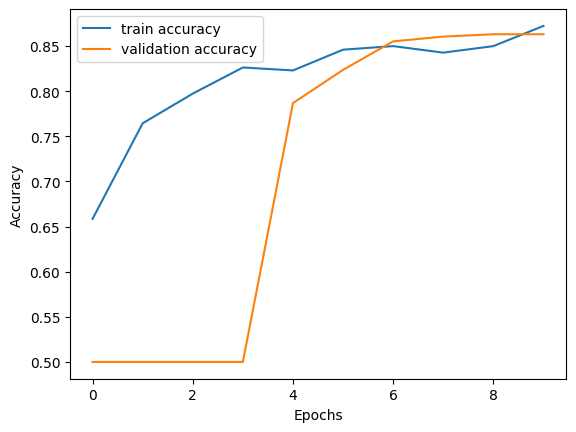

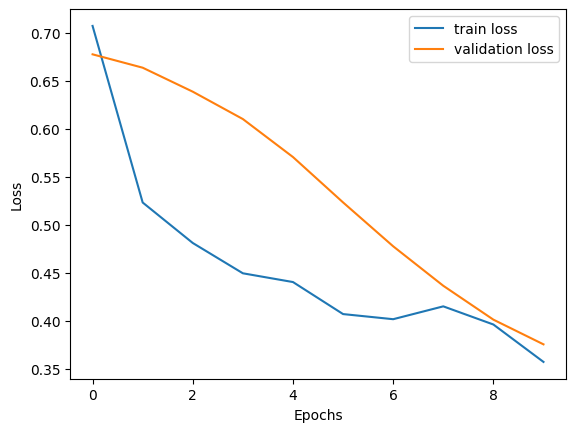

In [40]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


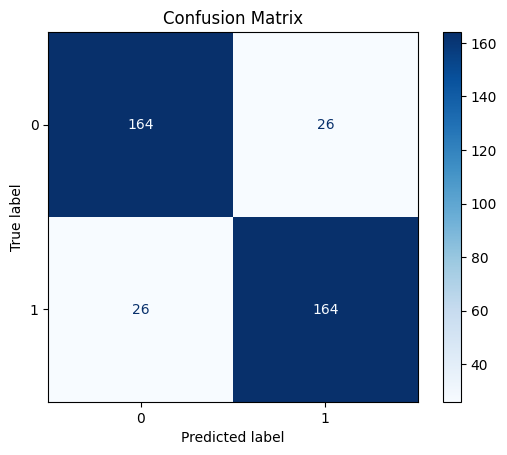

In [41]:
y_pred_prob = fusion_model.predict([X1_test, X2_test])
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


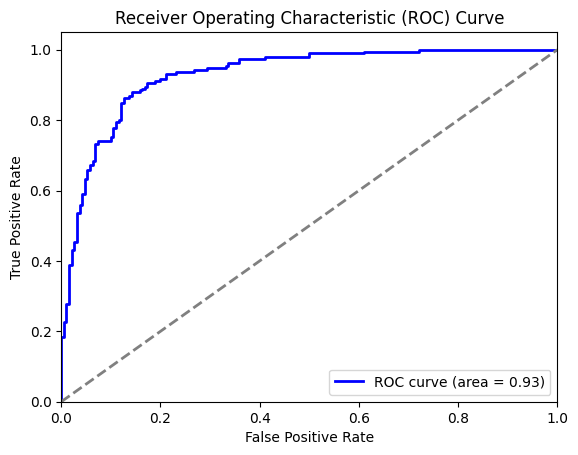

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
